# TimesNet for interpolation and forecasting
This notebook applies the TimesNet model—a deep learning architecture specifically designed for long-term time series forecasting—on air quality data (e.g., PM2.5) using spatial and contextual features.

## Interpolation

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from models.TimesNet import Model  # Ensure correct path
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# ---- Config ----
seq_len = 168  # 1 week
pred_len = 24  # predict next 24 hours
context_len = 72
batch_size = 32
d_model = 64
epochs = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# ---- Load Data ----
df = pd.read_csv('/home/meenakshi.p1798/meenakshi_work/merged_exact_on_lat_long.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values('Timestamp')

### Input Features = Spatial Features

In [ ]:
# ---- Spatial Features Only ----
features = ['latitude', 'longitude', 'average_road_density']
target_feature = ['PM2.5']

In [ ]:
# ---- Dataset Class ----
class TimesNetDataset(Dataset):
    def __init__(self, df, seq_len, pred_len, context_len, feature_scaler=None, target_scaler=None):
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.context_len = context_len

        if feature_scaler is None:
            self.feature_scaler = StandardScaler()
            df[features] = self.feature_scaler.fit_transform(df[features])
        else:
            self.feature_scaler = feature_scaler
            df[features] = self.feature_scaler.transform(df[features])

        if target_scaler is None:
            self.target_scaler = StandardScaler()
            df[target_feature] = self.target_scaler.fit_transform(df[target_feature])
        else:
            self.target_scaler = target_scaler
            df[target_feature] = self.target_scaler.transform(df[target_feature])

        self.data = df[target_feature + features].values

    def __len__(self):
        return len(self.data) - self.seq_len - self.context_len - self.pred_len

    def __getitem__(self, idx):
        s = idx
        e = s + self.seq_len
        c = e + self.context_len
        p = c + self.pred_len

        x_enc = torch.tensor(self.data[s:e], dtype=torch.float32)
        x_dec = torch.tensor(self.data[e:c], dtype=torch.float32)
        y = torch.tensor(self.data[c:p, 0], dtype=torch.float32)

        return x_enc, x_dec, y

In [ ]:
# ---- Config Class ----
class Configs:
    def __init__(self):
        self.task_name = 'long_term_forecast'
        self.seq_len = seq_len
        self.label_len = context_len
        self.pred_len = pred_len
        self.enc_in = len(features) + 1  # +1 for PM2.5 target in encoder
        self.dec_in = len(features) + 1
        self.c_out = 1  # PM2.5
        self.d_model = d_model
        self.embed = 'timeF'  # still required by model
        self.freq = 'h'
        self.dropout = 0.2
        self.e_layers = 2
        self.d_ff = 256
        self.num_kernels = 6
        self.top_k = 5
        self.activation = 'gelu'
        self.output_attention = False
        self.distil = True
        self.device = device


--- Training for Station: (28.6476, 77.3158) ---
Epoch 1/10 | Loss: 0.5970
Epoch 2/10 | Loss: 0.5423
Epoch 3/10 | Loss: 0.4792
Epoch 4/10 | Loss: 0.4021
Epoch 5/10 | Loss: 0.3100
Epoch 6/10 | Loss: 0.2418
Epoch 7/10 | Loss: 0.1993
Epoch 8/10 | Loss: 0.1592
Epoch 9/10 | Loss: 0.1378
Epoch 10/10 | Loss: 0.1102

--- Training for Station: (28.4986, 77.2648) ---
Epoch 1/10 | Loss: 0.4423
Epoch 2/10 | Loss: 0.3882
Epoch 3/10 | Loss: 0.3447
Epoch 4/10 | Loss: 0.3014
Epoch 5/10 | Loss: 0.2496
Epoch 6/10 | Loss: 0.2025
Epoch 7/10 | Loss: 0.1595
Epoch 8/10 | Loss: 0.1264
Epoch 9/10 | Loss: 0.0992
Epoch 10/10 | Loss: 0.0832

--- Training for Station: (28.6238, 77.2872) ---
Epoch 1/10 | Loss: 0.5830
Epoch 2/10 | Loss: 0.5194
Epoch 3/10 | Loss: 0.4718
Epoch 4/10 | Loss: 0.4067
Epoch 5/10 | Loss: 0.3132
Epoch 6/10 | Loss: 0.2465
Epoch 7/10 | Loss: 0.1972
Epoch 8/10 | Loss: 0.1474
Epoch 9/10 | Loss: 0.1223
Epoch 10/10 | Loss: 0.1057

--- Training for Station: (28.6740, 77.1310) ---
Epoch 1/10 | Loss

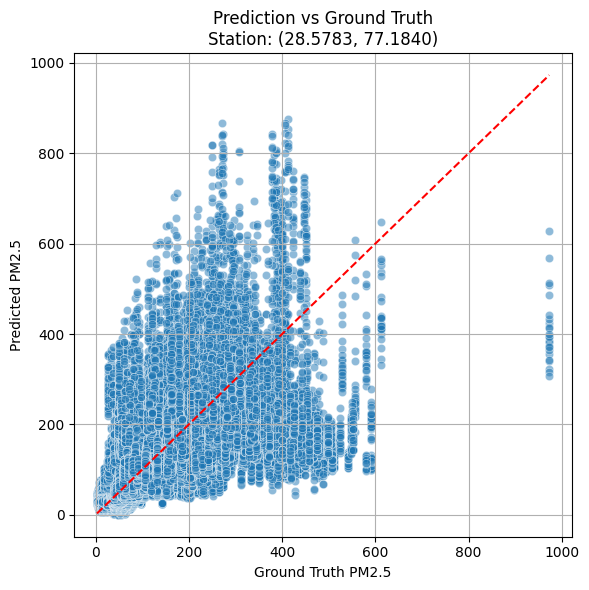

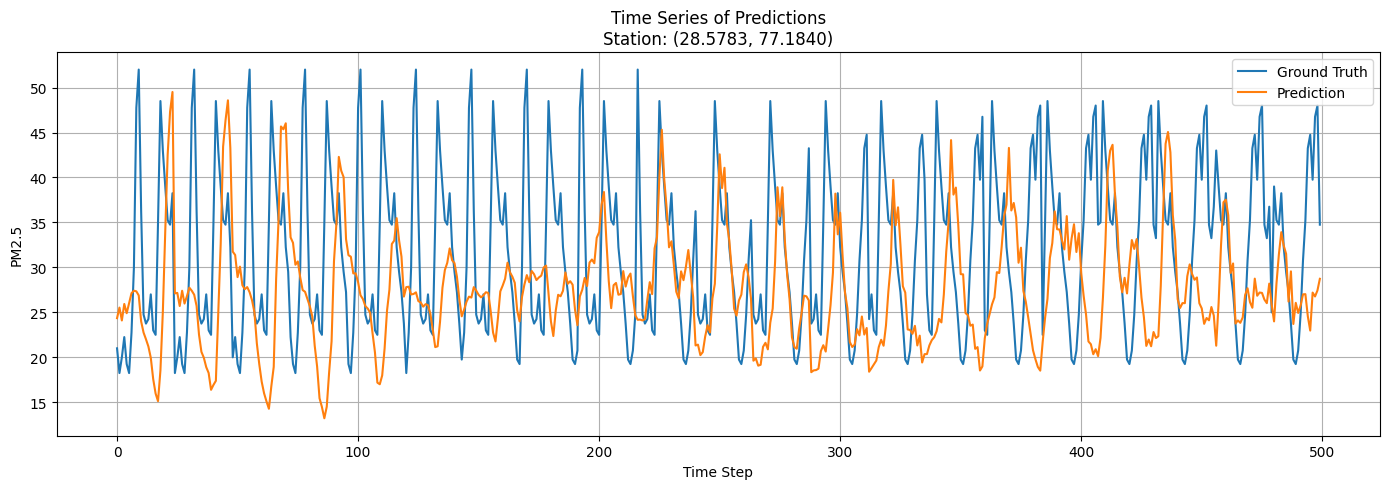

In [ ]:
# ---- Train & Evaluate per Station ----
results = []
unique_stations = df[['latitude', 'longitude']].drop_duplicates().values

for lat, lon in unique_stations:
    print(f"\n--- Training for Station: ({lat:.4f}, {lon:.4f}) ---")

    df_station = df[(df['latitude'] == lat) & (df['longitude'] == lon)].copy()
    df_station['month'] = df_station['Timestamp'].dt.month
    train_df = df_station[df_station['month'] <= 6]
    test_df = df_station[df_station['month'] > 6]

    if len(train_df) < seq_len + context_len + pred_len or len(test_df) < pred_len:
        print("Skipping due to insufficient data.")
        continue

    # Fit scalers only on training data
    train_dataset = TimesNetDataset(train_df, seq_len, pred_len, context_len)
    test_dataset = TimesNetDataset(test_df, seq_len, pred_len, context_len,
                                   feature_scaler=train_dataset.feature_scaler,
                                   target_scaler=train_dataset.target_scaler)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    configs = Configs()
    model = Model(configs).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    # Training Loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x_enc, x_dec, y in train_loader:
            x_enc, x_dec, y = x_enc.to(device), x_dec.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x_enc, None, x_dec, None)  # No time markers
            out = out[:, -pred_len:, 0]
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss / len(train_loader):.4f}")

    # Evaluation
    model.eval()
    all_preds, all_truths = [], []
    with torch.no_grad():
        for x_enc, x_dec, y in test_loader:
            x_enc, x_dec = x_enc.to(device), x_dec.to(device)
            out = model(x_enc, None, x_dec, None)
            out = out[:, -pred_len:, 0]
            all_preds.append(out.cpu().numpy())
            all_truths.append(y.cpu().numpy())

    preds = np.concatenate(all_preds, axis=0)
    truths = np.concatenate(all_truths, axis=0)

    preds_denorm = train_dataset.target_scaler.inverse_transform(preds.reshape(-1, 1)).squeeze()
    truths_denorm = train_dataset.target_scaler.inverse_transform(truths.reshape(-1, 1)).squeeze()

    mae = mean_absolute_error(truths_denorm, preds_denorm)
    rmse = np.sqrt(mean_squared_error(truths_denorm, preds_denorm))
    r2 = r2_score(truths_denorm, preds_denorm)

    results.append({
        'Station': f'({lat:.4f}, {lon:.4f})',
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2
    })

# ---- Results Summary ----
results_df = pd.DataFrame(results)
print("\n\nEvaluation Summary (Denormalized):")
print(results_df.to_string(index=False))

import matplotlib.pyplot as plt
import seaborn as sns

# --- Plot: Predicted vs Ground Truth (Scatter Plot) ---
plt.figure(figsize=(6, 6))
sns.scatterplot(x=truths_denorm, y=preds_denorm, alpha=0.5)
plt.plot([truths_denorm.min(), truths_denorm.max()], [truths_denorm.min(), truths_denorm.max()], 'r--')
plt.xlabel('Ground Truth PM2.5')
plt.ylabel('Predicted PM2.5')
plt.title(f'Prediction vs Ground Truth\nStation: ({lat:.4f}, {lon:.4f})')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot: Time Series of Prediction vs Ground Truth (first N predictions) ---
N = 500  # number of points to show
plt.figure(figsize=(14, 5))
plt.plot(truths_denorm[:N], label='Ground Truth', linewidth=1.5)
plt.plot(preds_denorm[:N], label='Prediction', linewidth=1.5)
plt.title(f'Time Series of Predictions\nStation: ({lat:.4f}, {lon:.4f})')
plt.xlabel('Time Step')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Input Features = Temporal Features

In [ ]:
# Custom Dataset class (without time features)
class TimesNetImputeDataset(Dataset):
    def __init__(self, df, seq_len):
        self.seq_len = seq_len

        # Only spatial + static features
        self.feature_cols = ['hour_sin', 'hour_cos', 'day', 'month']
        self.target_col = ['PM2.5']

        # Normalize
        self.feature_scaler = StandardScaler()
        self.target_scaler = StandardScaler()

        df[self.feature_cols] = self.feature_scaler.fit_transform(df[self.feature_cols])
        df[self.target_col] = self.target_scaler.fit_transform(df[self.target_col])

        self.X_enc, self.X_dec = [], []
        self.masks, self.timestamps = [], []

        for i in range(len(df) - seq_len):
            enc_seq = df.iloc[i:i + seq_len]
            self.X_enc.append(enc_seq[self.feature_cols + self.target_col].values)
            self.X_dec.append(enc_seq[self.feature_cols + self.target_col].values)
            self.masks.append(np.ones((seq_len, 1)))  # No missing data
            self.timestamps.append(enc_seq['Timestamp'].values[-1])

        # Convert to tensors
        self.X_enc = torch.tensor(np.array(self.X_enc), dtype=torch.float32)
        self.X_dec = torch.tensor(np.array(self.X_dec), dtype=torch.float32)
        self.masks = torch.tensor(np.array(self.masks), dtype=torch.float32)
        self.timestamps = np.array(self.timestamps)

    def __len__(self):
        return len(self.X_enc)

    def __getitem__(self, idx):
        timestamp = float(self.timestamps[idx].astype('datetime64[s]').astype(int))
        return (
            self.X_enc[idx],
            self.X_dec[idx],
            self.masks[idx],
            timestamp
        )

# Create dataset and split
dataset = TimesNetImputeDataset(df, seq_len)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
# Import TimesNet model
from models.TimesNet import Model as TimesNet

# Model config
class Configs:
    def __init__(self):
        self.seq_len = seq_len
        self.label_len = 0
        self.pred_len = 0
        self.enc_in = len(dataset.feature_cols) + 1  # +1 for PM2.5
        self.dec_in = self.enc_in
        self.c_out = 1
        self.d_model = 64
        self.embed = 'none'  # <-- No time embedding
        self.freq = 'h'
        self.dropout = 0.2
        self.n_heads = 4
        self.e_layers = 2
        self.d_ff = 256
        self.moving_avg = 25
        self.top_k = 5
        self.num_kernels = 6
        self.factor = 3
        self.activation = 'gelu'
        self.output_attention = False
        self.distil = True
        self.task_name = 'imputation'
        self.device = device

configs = Configs()
model = TimesNet(configs).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


🚀 Training TimesNet (no time features)...
Epoch 1/10, Loss: 0.0790
Epoch 2/10, Loss: 0.0759
Epoch 3/10, Loss: 0.0753
Epoch 4/10, Loss: 0.0747
Epoch 5/10, Loss: 0.0743
Epoch 6/10, Loss: 0.0739
Epoch 7/10, Loss: 0.0735
Epoch 8/10, Loss: 0.0730
Epoch 9/10, Loss: 0.0725
Epoch 10/10, Loss: 0.0720

🧪 Evaluating...

✅ Evaluation Metrics:
MAE: 23.05
RMSE: 35.75
R²: 0.87


NameError: name 'lat' is not defined

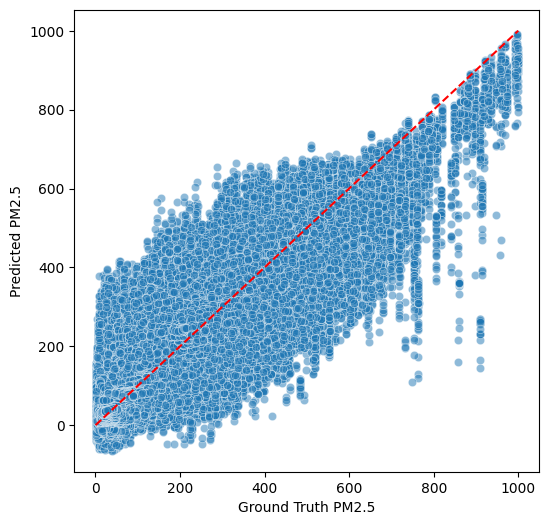

In [ ]:
# --- Training ---
print("\n🚀 Training TimesNet (no time features)...")
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x_enc, x_dec, mask, timestamp in train_loader:
        x_enc = x_enc.to(device)
        x_dec = x_dec.to(device)
        mask = mask.to(device)

        optimizer.zero_grad()
        imputed = model.imputation(x_enc, None, x_dec, None, mask)
        loss = criterion(imputed, x_enc)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# --- Evaluation ---
print("\n🧪 Evaluating...")
model.eval()
all_preds, all_truths, all_times = [], [], []

with torch.no_grad():
    for x_enc, x_dec, mask, timestamp in test_loader:
        x_enc = x_enc.to(device)
        x_dec = x_dec.to(device)
        mask = mask.to(device)

        imputed = model.imputation(x_enc, None, x_dec, None, mask)
        all_preds.append(imputed[:, :, -1].cpu().numpy())  # PM2.5 is last column
        all_truths.append(x_enc[:, :, -1].cpu().numpy())
        all_times.extend(timestamp)

# Combine all sequences
preds = np.concatenate(all_preds, axis=0)
truths = np.concatenate(all_truths, axis=0)

# Denormalize
preds_denorm = dataset.target_scaler.inverse_transform(preds.reshape(-1, 1)).squeeze()
truths_denorm = dataset.target_scaler.inverse_transform(truths.reshape(-1, 1)).squeeze()

# Metrics
mae = mean_absolute_error(truths_denorm, preds_denorm)
rmse = np.sqrt(mean_squared_error(truths_denorm, preds_denorm))
r2 = r2_score(truths_denorm, preds_denorm)

print(f"\n✅ Evaluation Metrics:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

import matplotlib.pyplot as plt
import seaborn as sns

# --- Plot: Predicted vs Ground Truth (Scatter Plot) ---
plt.figure(figsize=(6, 6))
sns.scatterplot(x=truths_denorm, y=preds_denorm, alpha=0.5)
plt.plot([truths_denorm.min(), truths_denorm.max()], [truths_denorm.min(), truths_denorm.max()], 'r--')
plt.xlabel('Ground Truth PM2.5')
plt.ylabel('Predicted PM2.5')
plt.title(f'Prediction vs Ground Truth\nStation: ({lat:.4f}, {lon:.4f})')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot: Time Series of Prediction vs Ground Truth (first N predictions) ---
N = 500  # number of points to show
plt.figure(figsize=(14, 5))
plt.plot(truths_denorm[:N], label='Ground Truth', linewidth=1.5)
plt.plot(preds_denorm[:N], label='Prediction', linewidth=1.5)
plt.title(f'Time Series of Predictions\nStation: ({lat:.4f}, {lon:.4f})')
plt.xlabel('Time Step')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

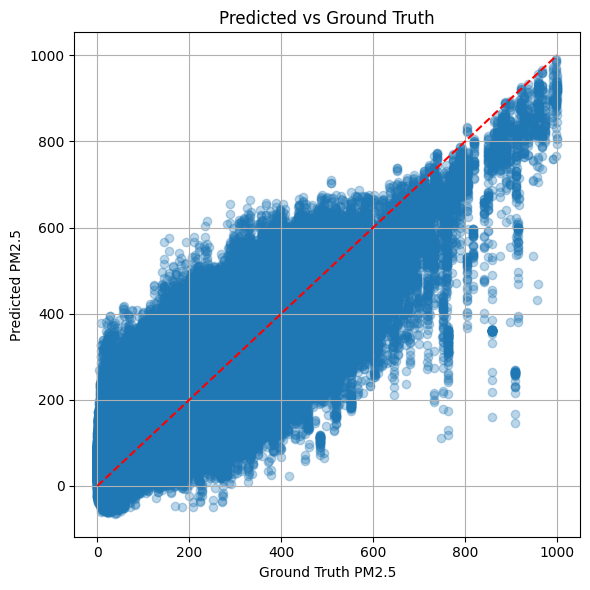

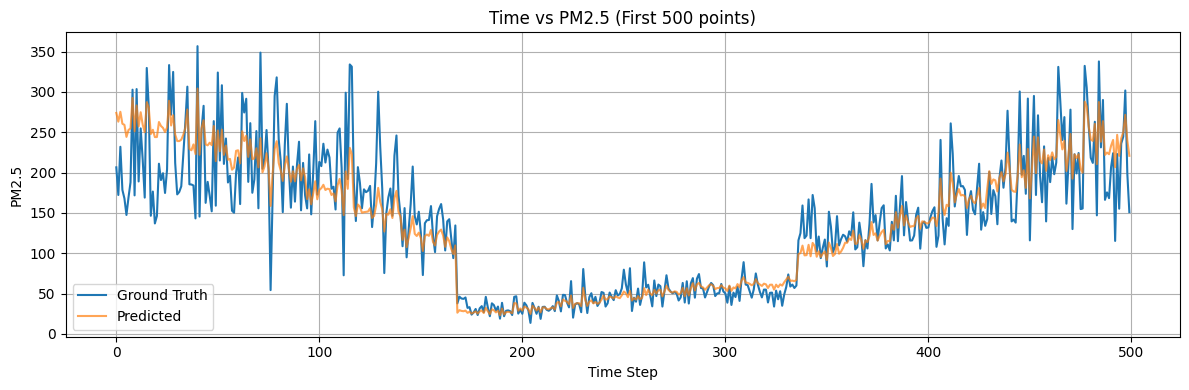

In [ ]:
# --- Plot 1: Predicted vs Ground Truth ---
plt.figure(figsize=(6, 6))
plt.scatter(truths_denorm, preds_denorm, alpha=0.3)
plt.xlabel("Ground Truth PM2.5")
plt.ylabel("Predicted PM2.5")
plt.title("Predicted vs Ground Truth")
plt.plot([truths_denorm.min(), truths_denorm.max()], [truths_denorm.min(), truths_denorm.max()], 'r--')
plt.grid()
plt.tight_layout()
plt.show()

# --- Plot 2: Time vs PM2.5 ---
plt.figure(figsize=(12, 4))
plt.plot(truths_denorm[:500], label='Ground Truth')
plt.plot(preds_denorm[:500], label='Predicted', alpha=0.7)
plt.title("Time vs PM2.5 (First 500 points)")
plt.xlabel("Time Step")
plt.ylabel("PM2.5")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

### Input Features = Spatial + Meteorological Features

In [ ]:
# Custom Dataset class (without time features)
class TimesNetImputeDataset(Dataset):
    def __init__(self, df, seq_len):
        self.seq_len = seq_len

        # Only spatial + static features
        self.feature_cols = ['latitude', 'longitude', 'average_road_density','AT', 'TOT-RF', 'BP', 'RF', 'WD', 'RH', 'WS', 'SR']
        self.target_col = ['PM2.5']

        # Normalize
        self.feature_scaler = StandardScaler()
        self.target_scaler = StandardScaler()

        df[self.feature_cols] = self.feature_scaler.fit_transform(df[self.feature_cols])
        df[self.target_col] = self.target_scaler.fit_transform(df[self.target_col])

        self.X_enc, self.X_dec = [], []
        self.masks, self.timestamps = [], []

        for i in range(len(df) - seq_len):
            enc_seq = df.iloc[i:i + seq_len]
            self.X_enc.append(enc_seq[self.feature_cols + self.target_col].values)
            self.X_dec.append(enc_seq[self.feature_cols + self.target_col].values)
            self.masks.append(np.ones((seq_len, 1)))  # No missing data
            self.timestamps.append(enc_seq['Timestamp'].values[-1])

        # Convert to tensors
        self.X_enc = torch.tensor(np.array(self.X_enc), dtype=torch.float32)
        self.X_dec = torch.tensor(np.array(self.X_dec), dtype=torch.float32)
        self.masks = torch.tensor(np.array(self.masks), dtype=torch.float32)
        self.timestamps = np.array(self.timestamps)

    def __len__(self):
        return len(self.X_enc)

    def __getitem__(self, idx):
        timestamp = float(self.timestamps[idx].astype('datetime64[s]').astype(int))
        return (
            self.X_enc[idx],
            self.X_dec[idx],
            self.masks[idx],
            timestamp
        )

# Create dataset and split
dataset = TimesNetImputeDataset(df, seq_len)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
# Import TimesNet model
from models.TimesNet import Model as TimesNet

# Model config
class Configs:
    def __init__(self):
        self.seq_len = seq_len
        self.label_len = 0
        self.pred_len = 0
        self.enc_in = len(dataset.feature_cols) + 1  # +1 for PM2.5
        self.dec_in = self.enc_in
        self.c_out = 1
        self.d_model = 64
        self.embed = 'none'  # <-- No time embedding
        self.freq = 'h'
        self.dropout = 0.2
        self.n_heads = 4
        self.e_layers = 2
        self.d_ff = 256
        self.moving_avg = 25
        self.top_k = 5
        self.num_kernels = 6
        self.factor = 3
        self.activation = 'gelu'
        self.output_attention = False
        self.distil = True
        self.task_name = 'imputation'
        self.device = device

configs = Configs()
model = TimesNet(configs).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


🚀 Training TimesNet (no time features)...
Epoch 1/10, Loss: 0.5885
Epoch 2/10, Loss: 0.5474
Epoch 3/10, Loss: 0.5363
Epoch 4/10, Loss: 0.5326
Epoch 5/10, Loss: 0.5299
Epoch 6/10, Loss: 0.5282
Epoch 7/10, Loss: 0.5270
Epoch 8/10, Loss: 0.5259
Epoch 9/10, Loss: 0.5250
Epoch 10/10, Loss: 0.5250

🧪 Evaluating...

✅ Evaluation Metrics:
MAE: 26.88
RMSE: 42.59
R²: 0.82


NameError: name 'lat' is not defined

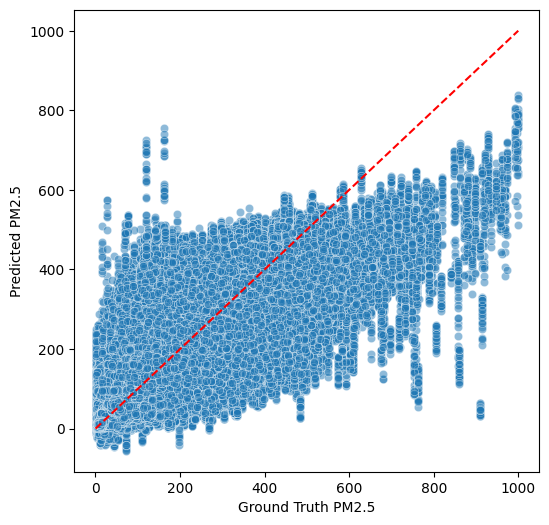

In [ ]:
# --- Training ---
print("\n🚀 Training TimesNet (no time features)...")
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x_enc, x_dec, mask, timestamp in train_loader:
        x_enc = x_enc.to(device)
        x_dec = x_dec.to(device)
        mask = mask.to(device)

        optimizer.zero_grad()
        imputed = model.imputation(x_enc, None, x_dec, None, mask)
        loss = criterion(imputed, x_enc)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# --- Evaluation ---
print("\n🧪 Evaluating...")
model.eval()
all_preds, all_truths, all_times = [], [], []

with torch.no_grad():
    for x_enc, x_dec, mask, timestamp in test_loader:
        x_enc = x_enc.to(device)
        x_dec = x_dec.to(device)
        mask = mask.to(device)

        imputed = model.imputation(x_enc, None, x_dec, None, mask)
        all_preds.append(imputed[:, :, -1].cpu().numpy())  # PM2.5 is last column
        all_truths.append(x_enc[:, :, -1].cpu().numpy())
        all_times.extend(timestamp)

# Combine all sequences
preds = np.concatenate(all_preds, axis=0)
truths = np.concatenate(all_truths, axis=0)

# Denormalize
preds_denorm = dataset.target_scaler.inverse_transform(preds.reshape(-1, 1)).squeeze()
truths_denorm = dataset.target_scaler.inverse_transform(truths.reshape(-1, 1)).squeeze()

# Metrics
mae = mean_absolute_error(truths_denorm, preds_denorm)
rmse = np.sqrt(mean_squared_error(truths_denorm, preds_denorm))
r2 = r2_score(truths_denorm, preds_denorm)

print(f"\n✅ Evaluation Metrics:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")



import matplotlib.pyplot as plt
import seaborn as sns

# --- Plot: Predicted vs Ground Truth (Scatter Plot) ---
plt.figure(figsize=(6, 6))
sns.scatterplot(x=truths_denorm, y=preds_denorm, alpha=0.5)
plt.plot([truths_denorm.min(), truths_denorm.max()], [truths_denorm.min(), truths_denorm.max()], 'r--')
plt.xlabel('Ground Truth PM2.5')
plt.ylabel('Predicted PM2.5')
plt.title(f'Prediction vs Ground Truth\nStation: ({lat:.4f}, {lon:.4f})')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot: Time Series of Prediction vs Ground Truth (first N predictions) ---
N = 500  # number of points to show
plt.figure(figsize=(14, 5))
plt.plot(truths_denorm[:N], label='Ground Truth', linewidth=1.5)
plt.plot(preds_denorm[:N], label='Prediction', linewidth=1.5)
plt.title(f'Time Series of Predictions\nStation: ({lat:.4f}, {lon:.4f})')
plt.xlabel('Time Step')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

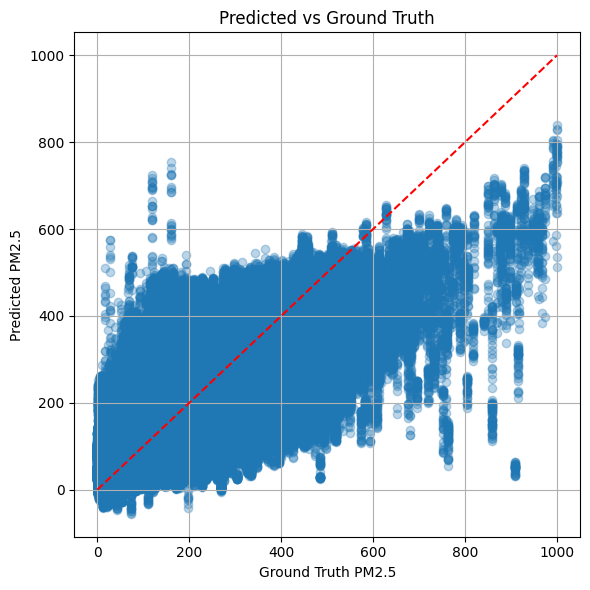

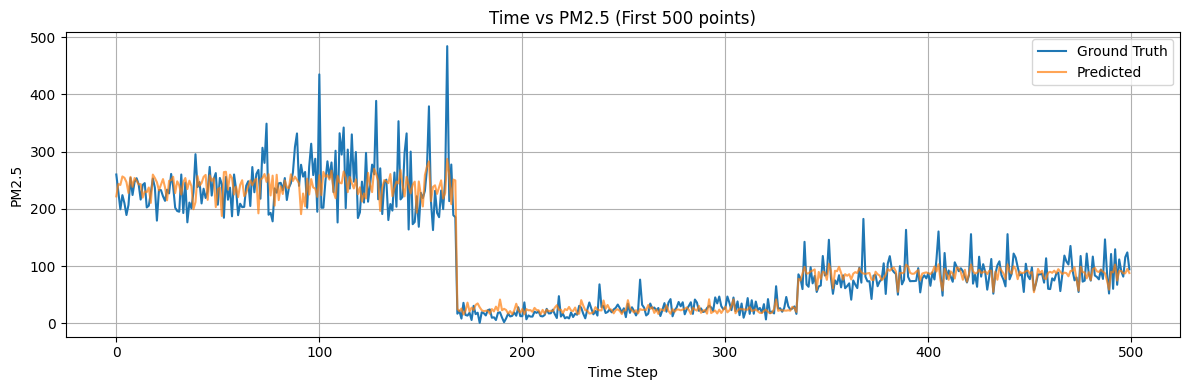

In [ ]:
# --- Plot 1: Predicted vs Ground Truth ---
plt.figure(figsize=(6, 6))
plt.scatter(truths_denorm, preds_denorm, alpha=0.3)
plt.xlabel("Ground Truth PM2.5")
plt.ylabel("Predicted PM2.5")
plt.title("Predicted vs Ground Truth")
plt.plot([truths_denorm.min(), truths_denorm.max()], [truths_denorm.min(), truths_denorm.max()], 'r--')
plt.grid()
plt.tight_layout()
plt.show()

# --- Plot 2: Time vs PM2.5 ---
plt.figure(figsize=(12, 4))
plt.plot(truths_denorm[:500], label='Ground Truth')
plt.plot(preds_denorm[:500], label='Predicted', alpha=0.7)
plt.title("Time vs PM2.5 (First 500 points)")
plt.xlabel("Time Step")
plt.ylabel("PM2.5")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

### Input Features = Spatial + Temporal + Meteorological Features

In [ ]:
# Custom Dataset class (without time features)
class TimesNetImputeDataset(Dataset):
    def __init__(self, df, seq_len):
        self.seq_len = seq_len

        # Only spatial + static features
        self.feature_cols = ['hour_sin', 'hour_cos', 'day', 'month', 'latitude', 'longitude', 'average_road_density', 'AT', 'TOT-RF', 'BP', 'RF', 'WD', 'RH', 'WS', 'SR']
        self.target_col = ['PM2.5']

        # Normalize
        self.feature_scaler = StandardScaler()
        self.target_scaler = StandardScaler()

        df[self.feature_cols] = self.feature_scaler.fit_transform(df[self.feature_cols])
        df[self.target_col] = self.target_scaler.fit_transform(df[self.target_col])

        self.X_enc, self.X_dec = [], []
        self.masks, self.timestamps = [], []

        for i in range(len(df) - seq_len):
            enc_seq = df.iloc[i:i + seq_len]
            self.X_enc.append(enc_seq[self.feature_cols + self.target_col].values)
            self.X_dec.append(enc_seq[self.feature_cols + self.target_col].values)
            self.masks.append(np.ones((seq_len, 1)))  # No missing data
            self.timestamps.append(enc_seq['Timestamp'].values[-1])

        # Convert to tensors
        self.X_enc = torch.tensor(np.array(self.X_enc), dtype=torch.float32)
        self.X_dec = torch.tensor(np.array(self.X_dec), dtype=torch.float32)
        self.masks = torch.tensor(np.array(self.masks), dtype=torch.float32)
        self.timestamps = np.array(self.timestamps)

    def __len__(self):
        return len(self.X_enc)

    def __getitem__(self, idx):
        timestamp = float(self.timestamps[idx].astype('datetime64[s]').astype(int))
        return (
            self.X_enc[idx],
            self.X_dec[idx],
            self.masks[idx],
            timestamp
        )

# Create dataset and split
dataset = TimesNetImputeDataset(df, seq_len)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
# Import TimesNet model
from models.TimesNet import Model as TimesNet

# Model config
class Configs:
    def __init__(self):
        self.seq_len = seq_len
        self.label_len = 0
        self.pred_len = 0
        self.enc_in = len(dataset.feature_cols) + 1  # +1 for PM2.5
        self.dec_in = self.enc_in
        self.c_out = 1
        self.d_model = 64
        self.embed = 'none'  # <-- No time embedding
        self.freq = 'h'
        self.dropout = 0.2
        self.n_heads = 4
        self.e_layers = 2
        self.d_ff = 256
        self.moving_avg = 25
        self.top_k = 5
        self.num_kernels = 6
        self.factor = 3
        self.activation = 'gelu'
        self.output_attention = False
        self.distil = True
        self.task_name = 'imputation'
        self.device = device

configs = Configs()
model = TimesNet(configs).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


🚀 Training TimesNet (no time features)...
Epoch 1/10, Loss: 0.4816
Epoch 2/10, Loss: 0.4525
Epoch 3/10, Loss: 0.4447
Epoch 4/10, Loss: 0.4415
Epoch 5/10, Loss: 0.4398
Epoch 6/10, Loss: 0.4384
Epoch 7/10, Loss: 0.4374
Epoch 8/10, Loss: 0.4367
Epoch 9/10, Loss: 0.4362
Epoch 10/10, Loss: 0.4357

🧪 Evaluating...

✅ Evaluation Metrics:
MAE: 26.85
RMSE: 43.21
R²: 0.82


NameError: name 'lat' is not defined

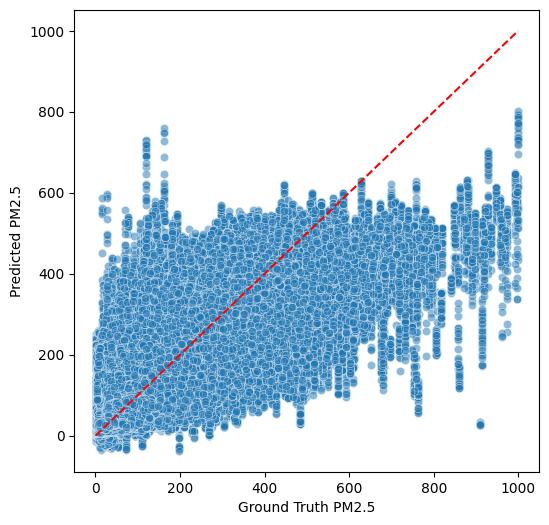

In [ ]:
# --- Training ---
print("\n🚀 Training TimesNet (no time features)...")
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x_enc, x_dec, mask, timestamp in train_loader:
        x_enc = x_enc.to(device)
        x_dec = x_dec.to(device)
        mask = mask.to(device)

        optimizer.zero_grad()
        imputed = model.imputation(x_enc, None, x_dec, None, mask)
        loss = criterion(imputed, x_enc)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# --- Evaluation ---
print("\n🧪 Evaluating...")
model.eval()
all_preds, all_truths, all_times = [], [], []

with torch.no_grad():
    for x_enc, x_dec, mask, timestamp in test_loader:
        x_enc = x_enc.to(device)
        x_dec = x_dec.to(device)
        mask = mask.to(device)

        imputed = model.imputation(x_enc, None, x_dec, None, mask)
        all_preds.append(imputed[:, :, -1].cpu().numpy())  # PM2.5 is last column
        all_truths.append(x_enc[:, :, -1].cpu().numpy())
        all_times.extend(timestamp)

# Combine all sequences
preds = np.concatenate(all_preds, axis=0)
truths = np.concatenate(all_truths, axis=0)

# Denormalize
preds_denorm = dataset.target_scaler.inverse_transform(preds.reshape(-1, 1)).squeeze()
truths_denorm = dataset.target_scaler.inverse_transform(truths.reshape(-1, 1)).squeeze()

# Metrics
mae = mean_absolute_error(truths_denorm, preds_denorm)
rmse = np.sqrt(mean_squared_error(truths_denorm, preds_denorm))
r2 = r2_score(truths_denorm, preds_denorm)

print(f"\n✅ Evaluation Metrics:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

import matplotlib.pyplot as plt
import seaborn as sns

# --- Plot: Predicted vs Ground Truth (Scatter Plot) ---
plt.figure(figsize=(6, 6))
sns.scatterplot(x=truths_denorm, y=preds_denorm, alpha=0.5)
plt.plot([truths_denorm.min(), truths_denorm.max()], [truths_denorm.min(), truths_denorm.max()], 'r--')
plt.xlabel('Ground Truth PM2.5')
plt.ylabel('Predicted PM2.5')
plt.title(f'Prediction vs Ground Truth\nStation: ({lat:.4f}, {lon:.4f})')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot: Time Series of Prediction vs Ground Truth (first N predictions) ---
N = 500  # number of points to show
plt.figure(figsize=(14, 5))
plt.plot(truths_denorm[:N], label='Ground Truth', linewidth=1.5)
plt.plot(preds_denorm[:N], label='Prediction', linewidth=1.5)
plt.title(f'Time Series of Predictions\nStation: ({lat:.4f}, {lon:.4f})')
plt.xlabel('Time Step')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

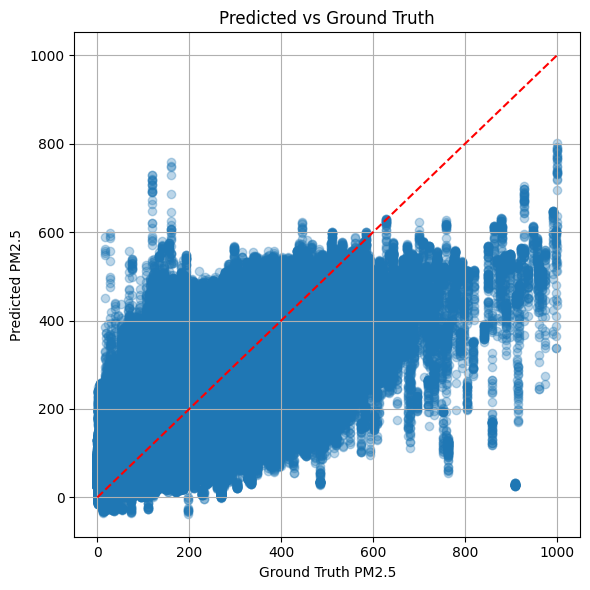

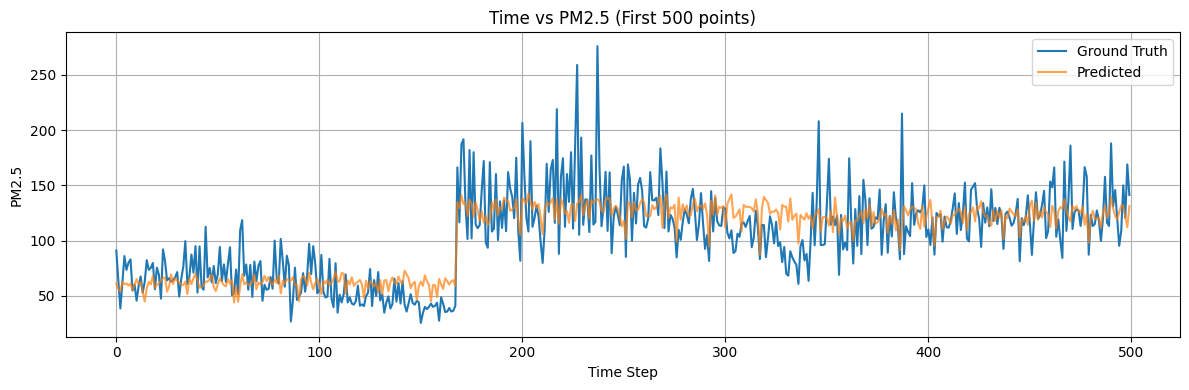

In [ ]:
# --- Plot 1: Predicted vs Ground Truth ---
plt.figure(figsize=(6, 6))
plt.scatter(truths_denorm, preds_denorm, alpha=0.3)
plt.xlabel("Ground Truth PM2.5")
plt.ylabel("Predicted PM2.5")
plt.title("Predicted vs Ground Truth")
plt.plot([truths_denorm.min(), truths_denorm.max()], [truths_denorm.min(), truths_denorm.max()], 'r--')
plt.grid()
plt.tight_layout()
plt.show()

# --- Plot 2: Time vs PM2.5 ---
plt.figure(figsize=(12, 4))
plt.plot(truths_denorm[:500], label='Ground Truth')
plt.plot(preds_denorm[:500], label='Predicted', alpha=0.7)
plt.title("Time vs PM2.5 (First 500 points)")
plt.xlabel("Time Step")
plt.ylabel("PM2.5")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

## Forecasting

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from datetime import datetime
from models.TimesNet import Model  # Ensure this is correct
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# ---- Load Data ----
df = pd.read_csv('/home/meenakshi.p1798/meenakshi_work/merged_exact_on_lat_long.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values('Timestamp')

In [ ]:
# ---- Config ----
seq_len = 168  # 1 week
pred_len = 24  # predict next 24 hours
context_len = 72  # decoder input
batch_size = 32
d_model = 64
epochs = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Feature Columns
time_features = ['month', 'day', 'weekday', 'hour']
spatial_features = ['latitude', 'longitude', 'average_road_density']
target_feature = ['PM2.5']

### Input Features = Spatial Features

In [ ]:
# ---- Dataset Class ----
class TimesNetDataset(Dataset):
    def __init__(self, df, seq_len, pred_len, context_len):
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.context_len = context_len

        df['month'] = df['Timestamp'].dt.month
        df['day'] = df['Timestamp'].dt.day
        df['hour'] = df['Timestamp'].dt.hour
        df['weekday'] = df['Timestamp'].dt.weekday

        # Separate scalers
        self.feature_scaler = StandardScaler()
        self.target_scaler = StandardScaler()

        df[spatial_features] = self.feature_scaler.fit_transform(df[spatial_features])
        df[target_feature] = self.target_scaler.fit_transform(df[target_feature])

        self.data = df[target_feature + spatial_features].values
        self.time = df[time_features].values

    def __len__(self):
        return len(self.data) - self.seq_len - self.context_len - self.pred_len

    def __getitem__(self, idx):
        s = idx
        e = s + self.seq_len
        c = e + self.context_len
        p = c + self.pred_len

        x_enc = torch.tensor(self.data[s:e], dtype=torch.float32)
        x_dec = torch.tensor(self.data[e:c], dtype=torch.float32)
        y = torch.tensor(self.data[c:p, 0], dtype=torch.float32)

        x_mark_enc = torch.tensor(self.time[s:e], dtype=torch.float32)
        x_mark_dec = torch.tensor(self.time[e:c], dtype=torch.float32)

        return x_enc, x_mark_enc, x_dec, x_mark_dec, y

In [ ]:
# ---- Config Class ----
class Configs:
    def __init__(self):
        self.task_name = 'long_term_forecast'
        self.seq_len = seq_len
        self.label_len = context_len
        self.pred_len = pred_len
        self.enc_in = 4  # PM2.5 + lat/lon + road_density
        self.dec_in = 4
        self.c_out = 1
        self.d_model = d_model
        self.embed = 'timeF'
        self.freq = 'h'
        self.dropout = 0.2
        self.e_layers = 2
        self.d_ff = 256
        self.num_kernels = 6
        self.top_k = 5
        self.activation = 'gelu'
        self.output_attention = False
        self.distil = True
        self.device = device


--- Training for Station: (28.6476, 77.3158) ---
Epoch 1/10 | Loss: 0.6365
Epoch 2/10 | Loss: 0.5234
Epoch 3/10 | Loss: 0.4917
Epoch 4/10 | Loss: 0.4398
Epoch 5/10 | Loss: 0.3484
Epoch 6/10 | Loss: 0.2974
Epoch 7/10 | Loss: 0.2478
Epoch 8/10 | Loss: 0.2121
Epoch 9/10 | Loss: 0.1720
Epoch 10/10 | Loss: 0.1371

--- Training for Station: (28.4986, 77.2648) ---
Epoch 1/10 | Loss: 0.4711
Epoch 2/10 | Loss: 0.3891
Epoch 3/10 | Loss: 0.3467
Epoch 4/10 | Loss: 0.3068
Epoch 5/10 | Loss: 0.2457
Epoch 6/10 | Loss: 0.1822
Epoch 7/10 | Loss: 0.1416
Epoch 8/10 | Loss: 0.1118
Epoch 9/10 | Loss: 0.0822
Epoch 10/10 | Loss: 0.0690

--- Training for Station: (28.6238, 77.2872) ---
Epoch 1/10 | Loss: 0.6310
Epoch 2/10 | Loss: 0.5021
Epoch 3/10 | Loss: 0.4456
Epoch 4/10 | Loss: 0.3833
Epoch 5/10 | Loss: 0.2986
Epoch 6/10 | Loss: 0.2289
Epoch 7/10 | Loss: 0.1919
Epoch 8/10 | Loss: 0.1713
Epoch 9/10 | Loss: 0.1481
Epoch 10/10 | Loss: 0.1321

--- Training for Station: (28.6740, 77.1310) ---
Epoch 1/10 | Loss

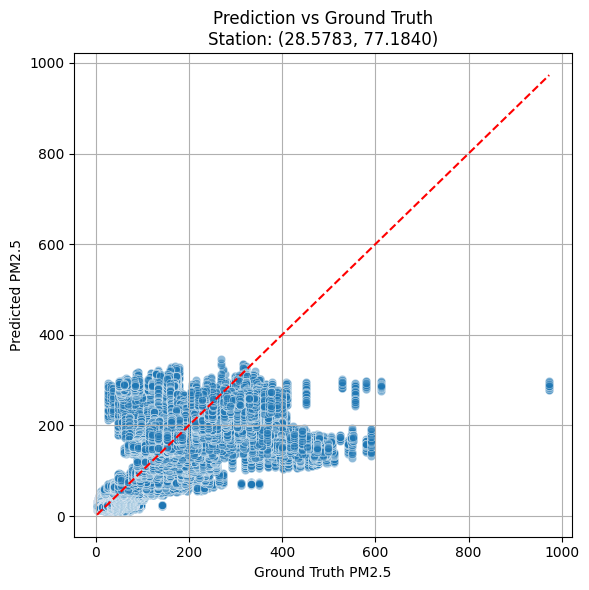

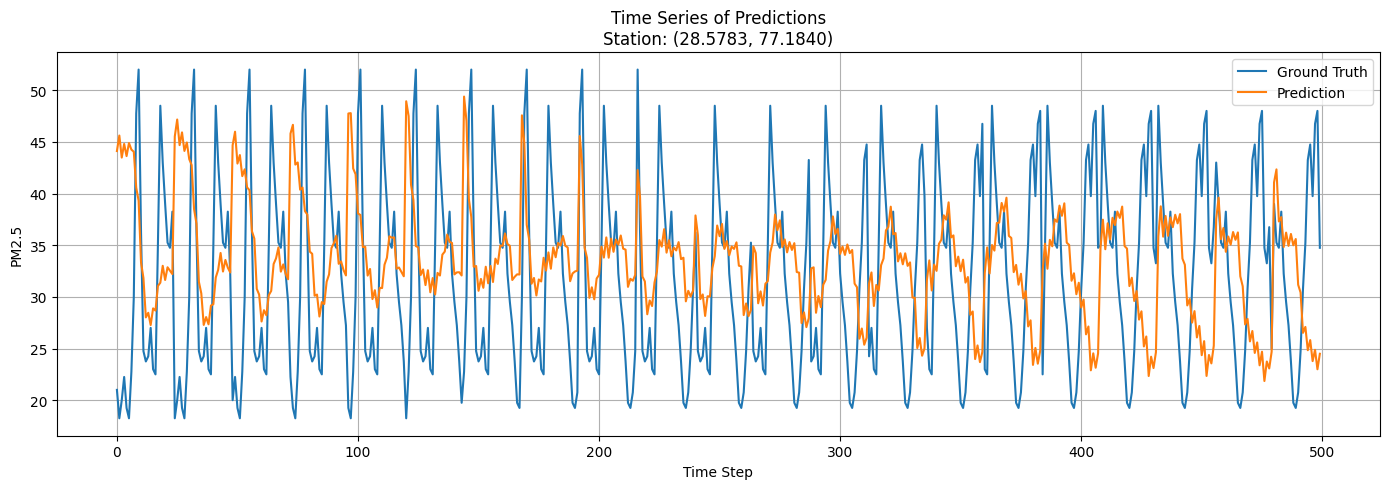

In [ ]:
# ---- Train & Evaluate per Station ----
results = []
unique_stations = df[['latitude', 'longitude']].drop_duplicates().values

for lat, lon in unique_stations:
    print(f"\n--- Training for Station: ({lat:.4f}, {lon:.4f}) ---")

    df_station = df[(df['latitude'] == lat) & (df['longitude'] == lon)].copy()

    # Split
    df_station['month'] = df_station['Timestamp'].dt.month
    train_df = df_station[df_station['month'] <= 6]
    test_df = df_station[df_station['month'] > 6]

    if len(train_df) < seq_len + context_len + pred_len or len(test_df) < pred_len:
        print("Skipping due to insufficient data.")
        continue

    train_dataset = TimesNetDataset(train_df, seq_len, pred_len, context_len)
    test_dataset = TimesNetDataset(test_df, seq_len, pred_len, context_len)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Model
    configs = Configs()
    model = Model(configs).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    # Training Loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x_enc, x_mark_enc, x_dec, x_mark_dec, y in train_loader:
            x_enc, x_mark_enc = x_enc.to(device), x_mark_enc.to(device)
            x_dec, x_mark_dec = x_dec.to(device), x_mark_dec.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            out = model(x_enc, x_mark_enc, x_dec, x_mark_dec)  # [B, T, 1]
            out = out[:, -pred_len:, 0]
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss / len(train_loader):.4f}")

    # Evaluation
    model.eval()
    all_preds, all_truths = [], []
    with torch.no_grad():
        for x_enc, x_mark_enc, x_dec, x_mark_dec, y in test_loader:
            x_enc, x_mark_enc = x_enc.to(device), x_mark_enc.to(device)
            x_dec, x_mark_dec = x_dec.to(device), x_mark_dec.to(device)
            y = y.to(device)

            out = model(x_enc, x_mark_enc, x_dec, x_mark_dec)
            out = out[:, -pred_len:, 0]

            all_preds.append(out.cpu().numpy())
            all_truths.append(y.cpu().numpy())

    preds = np.concatenate(all_preds, axis=0)
    truths = np.concatenate(all_truths, axis=0)

    # Denormalize
    # scaler = test_dataset.scaler
    # pad = np.zeros((preds.shape[0], len(spatial_features)))
    # #preds_denorm = scaler.inverse_transform(np.hstack([preds, pad]))[:, 0]
    # preds_denorm = target_scaler.inverse_transform(preds.reshape(-1, 1)).squeeze()
    # truths_denorm = scaler.inverse_transform(np.hstack([truths, pad]))[:, 0]

    target_scaler = test_dataset.target_scaler  # Now accessible
    preds_denorm = target_scaler.inverse_transform(preds.reshape(-1, 1)).squeeze()
    truths_denorm = target_scaler.inverse_transform(truths.reshape(-1, 1)).squeeze()

    # Metrics
    mae = mean_absolute_error(truths_denorm, preds_denorm)
    import numpy as np
    rmse = np.sqrt(np.mean((truths_denorm - preds_denorm) ** 2))
    r2 = r2_score(truths_denorm, preds_denorm)

    results.append({
        'Station': f'({lat:.4f}, {lon:.4f})',
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2
    })

# ---- Print Results ----
results_df = pd.DataFrame(results)
print("\n\n Evaluation Summary (Denormalized):")
print(results_df.to_string(index=False))

import matplotlib.pyplot as plt
import seaborn as sns

# --- Plot: Predicted vs Ground Truth (Scatter Plot) ---
plt.figure(figsize=(6, 6))
sns.scatterplot(x=truths_denorm, y=preds_denorm, alpha=0.5)
plt.plot([truths_denorm.min(), truths_denorm.max()], [truths_denorm.min(), truths_denorm.max()], 'r--')
plt.xlabel('Ground Truth PM2.5')
plt.ylabel('Predicted PM2.5')
plt.title(f'Prediction vs Ground Truth\nStation: ({lat:.4f}, {lon:.4f})')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot: Time Series of Prediction vs Ground Truth (first N predictions) ---
N = 500  # number of points to show
plt.figure(figsize=(14, 5))
plt.plot(truths_denorm[:N], label='Ground Truth', linewidth=1.5)
plt.plot(preds_denorm[:N], label='Prediction', linewidth=1.5)
plt.title(f'Time Series of Predictions\nStation: ({lat:.4f}, {lon:.4f})')
plt.xlabel('Time Step')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Compute mean metrics
mean_mae = results_df["MAE"].mean()
mean_rmse = results_df["RMSE"].mean()
mean_r2 = results_df["R²"].mean()

print(f"Mean MAE: {mean_mae:.4f}")
print(f"Mean RMSE: {mean_rmse:.4f}")
print(f"Mean R²: {mean_r2:.4f}")

Mean MAE: 52.3889
Mean RMSE: 82.9698
Mean R²: 0.4878
